# Metrics

This guide gives you a brief introduction to Rubrix Metrics. Rubrix Metrics enable you to perform fine-grained analyses of your models and training datasets. Rubrix Metrics are inspired by a a number of seminal works such as [Explainaboard](http://explainaboard.nlpedia.ai/). 

The main goal is to make it easier to build more robust models and training data, going beyond single-number metrics (e.g., F1). 

This guide gives a brief overview of currently supported metrics. For the full API documentation see the [Python API reference](../reference/python/python_metrics.rst)


.. nbinfo::
This feature is experimental, you can expect some changes in the Python API. Please report on Github any issue you encounter.


## Install dependencies

.. nbinfo::
Verify you have already installed Jupyter Widgets in order to properly visualize the plots.
See https://ipywidgets.readthedocs.io/en/latest/user_install.html

For running this guide you need to install the following dependencies:

In [ ]:
%pip install datasets spacy plotly -qqq

and the spacy model:

In [ ]:
!python -m spacy download en_core_web_sm

## 1. Rubrix Metrics for NER pipelines predictions

### Load dataset and spaCy model

We'll be using spaCy for this guide, but all the metrics we'll see are computed for any other framework (Flair, Stanza, Hugging Face, etc.). As an example will use the WNUT17 NER dataset.

In [ ]:
import rubrix as rb
import spacy
from datasets import load_dataset

nlp = spacy.load("en_core_web_sm")
dataset = load_dataset("wnut_17", split="train")

### Log records into a Rubrix dataset

Let's log spaCy predictions using the built-in `rb.monitor` method:

In [ ]:
nlp = rb.monitor(nlp, dataset="spacy_sm_wnut17")

def predict(record):
    doc = nlp(" ".join(record["tokens"]))
    return {"predicted": True}

dataset.map(predict)

### Explore some metrics for this pipeline

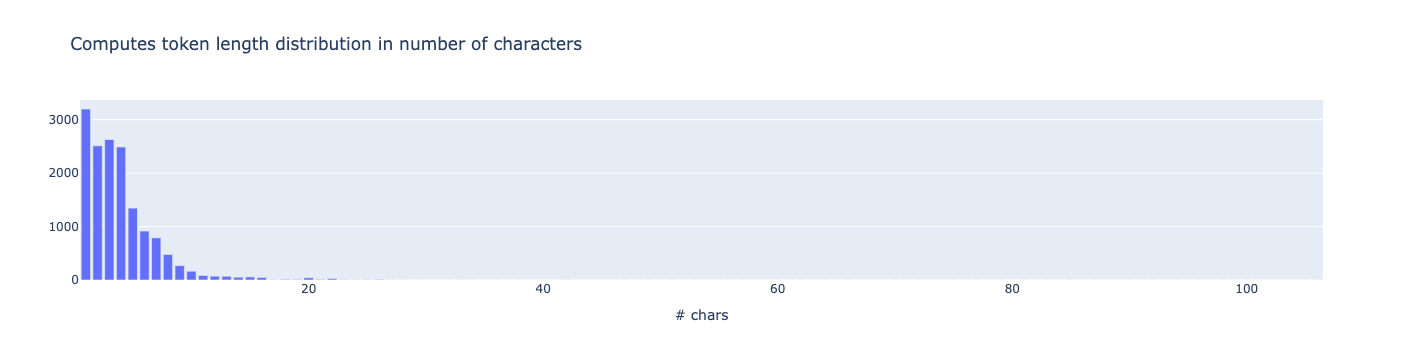

In [17]:
from rubrix.metrics.token_classification import token_length

token_length(name="spacy_sm_wnut17").visualize()

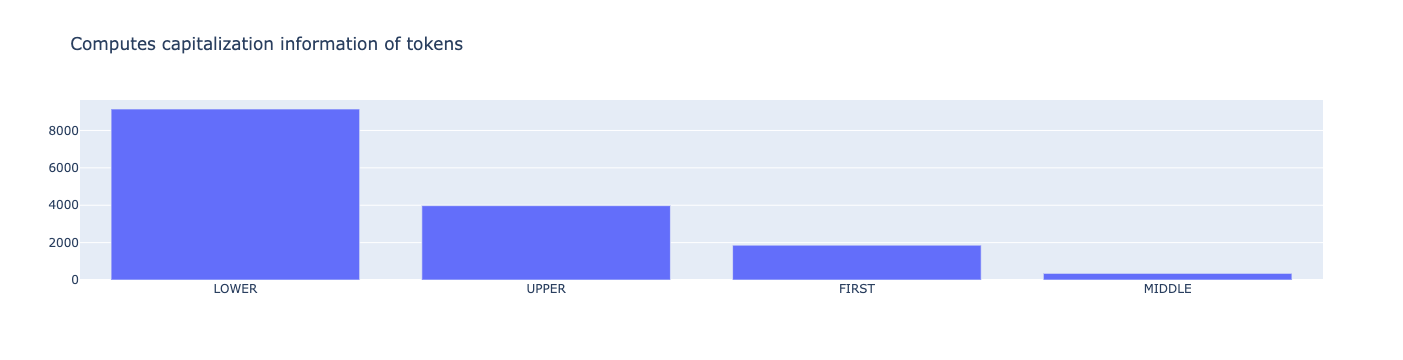

In [18]:
from rubrix.metrics.token_classification import token_capitalness

token_capitalness(name="spacy_sm_wnut17").visualize()

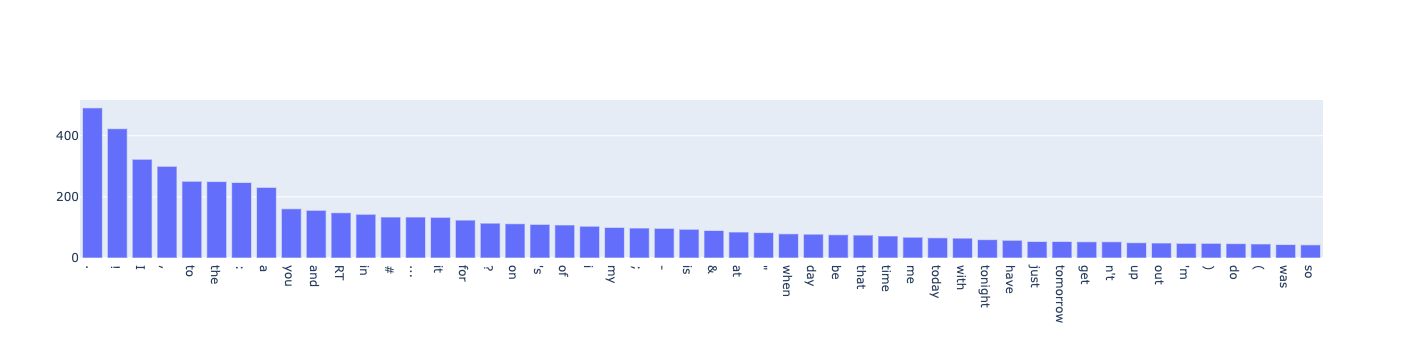

In [20]:
from rubrix.metrics.token_classification import token_frequency

token_frequency(name="spacy_sm_wnut17", tokens=50).visualize()

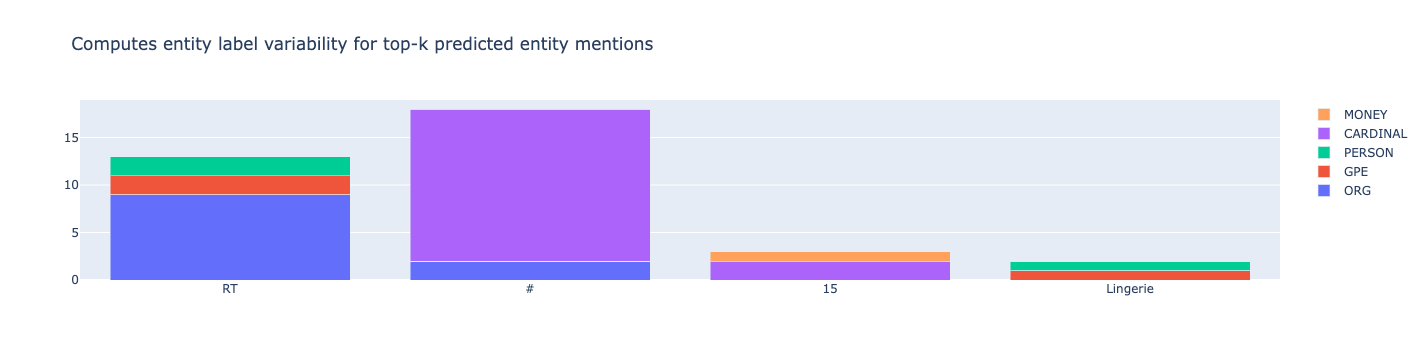

In [21]:
from rubrix.metrics.token_classification import entity_consistency

entity_consistency(name="spacy_sm_wnut17", mentions=5000, threshold=2).visualize()

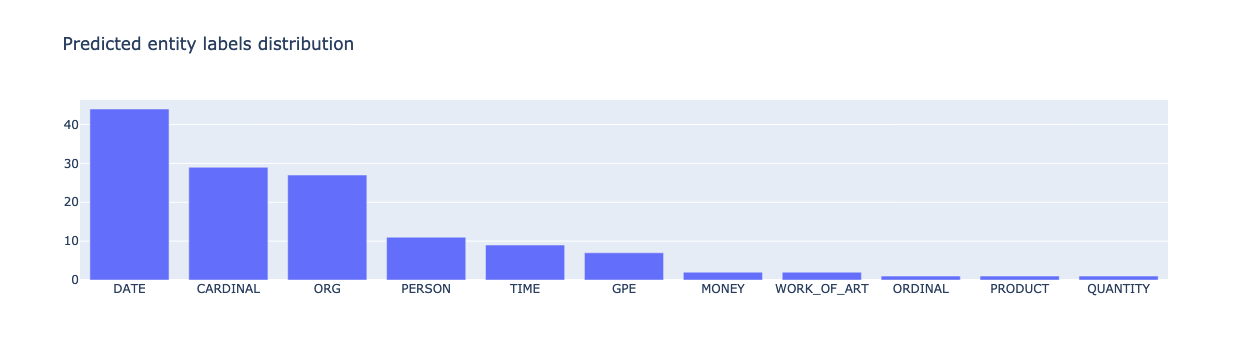

In [5]:
from rubrix.metrics.token_classification import entity_labels

entity_labels(name="spacy_sm_wnut17").visualize()

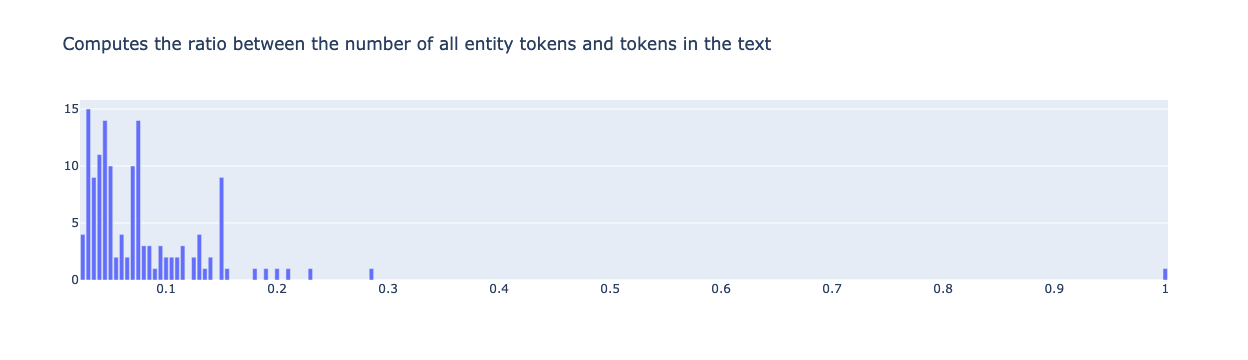

In [6]:
from rubrix.metrics.token_classification import entity_density

entity_density(name="spacy_sm_wnut17").visualize()

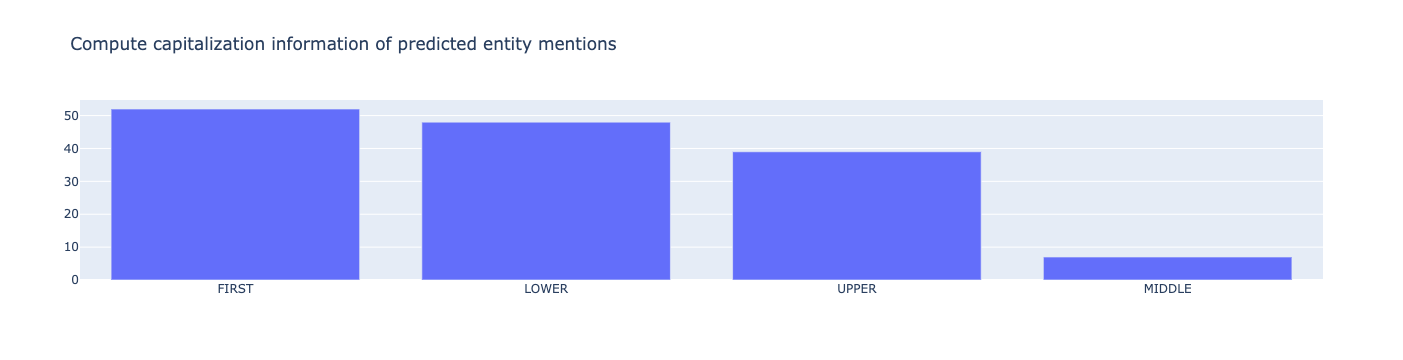

In [7]:
from rubrix.metrics.token_classification import entity_capitalness

entity_capitalness(name="spacy_sm_wnut17").visualize()

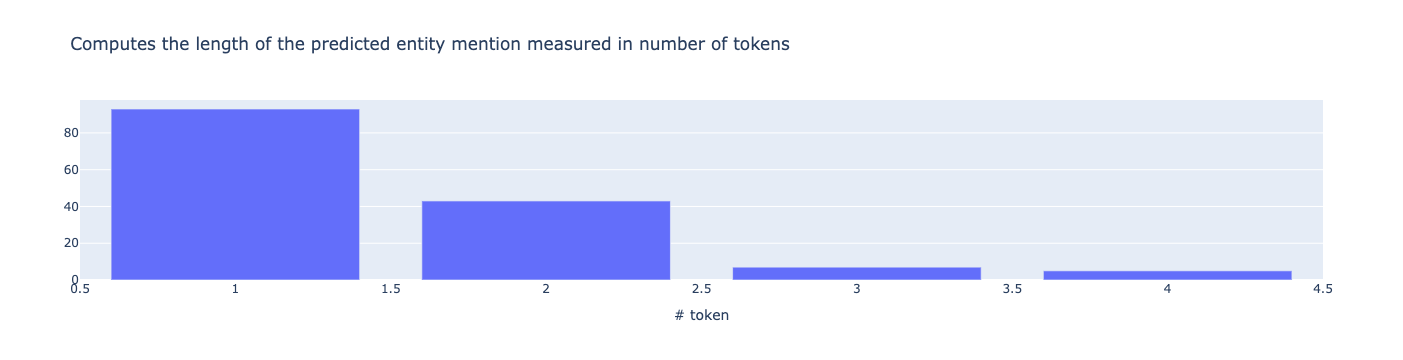

In [8]:
from rubrix.metrics.token_classification import mention_length
mention_length(name="spacy_sm_wnut17").visualize()

## 2. Rubrix Metrics for NER training sets

### Analyzing tags

Let's analyze the conll2002 dataset at the tag level.

In [ ]:
dataset = load_dataset("conll2002", "es", split="train[0:5000]")

In [24]:
def parse_entities(record):
    entities = []
    counter = 0
    for i in range(len(record['ner_tags'])):
        entity = (dataset.features["ner_tags"].feature.names[record["ner_tags"][i]], counter, counter + len(record["tokens"][i]))
        entities.append(entity)
        counter += len(record["tokens"][i]) + 1
    return entities

In [30]:
records = [
    rb.TokenClassificationRecord(
        text=" ".join(example["tokens"]),
        tokens=example["tokens"],
        annotation=parse_entities(example)
    )
    for example in dataset
] 

In [ ]:
rb.log(records, "conll2002_es")

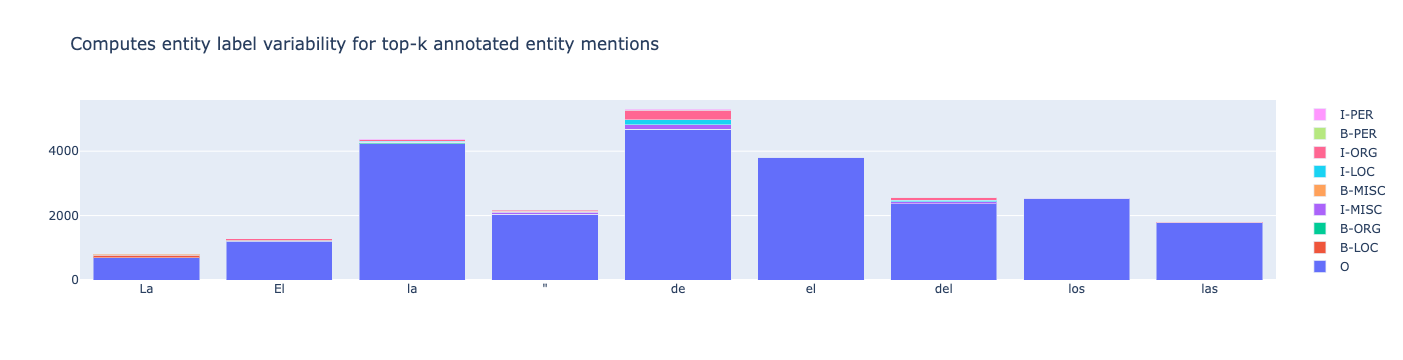

In [51]:
from rubrix.metrics.token_classification import entity_consistency
from rubrix.metrics.token_classification.metrics import Annotations

entity_consistency(name="conll2002_es", mentions=30, threshold=4, compute_for=Annotations).visualize()

From the above we see we can quickly detect an annotation issue: double quotes `"` are most of the time tagged as `O` (no entity) but in some cases (~60 examples) are tagged as beginning of entities like ORG or MISC, which is likely a hand-labelling error, including the quotes inside the entity span.

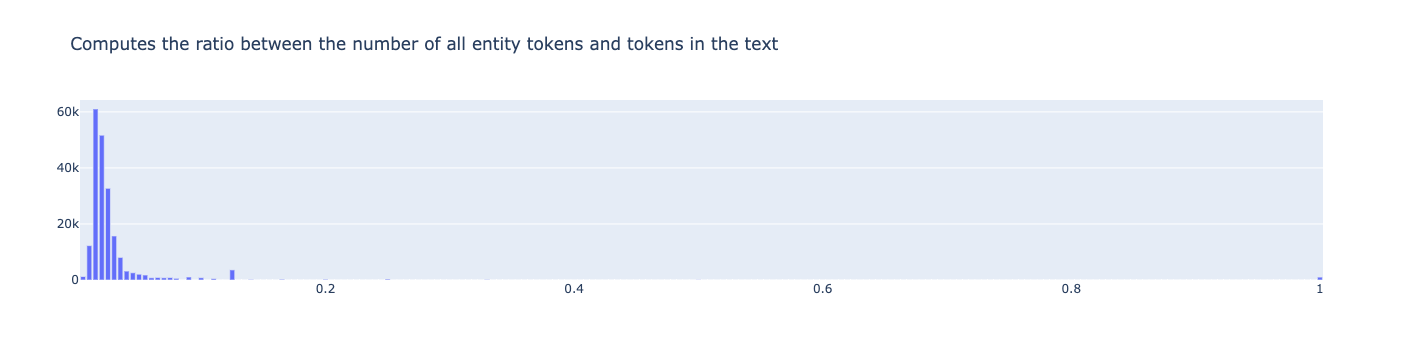

In [54]:
from rubrix.metrics.token_classification import *

entity_density(name="conll2002_es", compute_for=Annotations).visualize()

## 2. Rubrix Metrics for text classification

In [ ]:
from datasets import load_dataset
from transformers import pipeline

import rubrix as rb

sst2 = load_dataset("glue", "sst2", split="validation")
labels = sst2.features["label"].names
nlp = pipeline("sentiment-analysis")

In [11]:
records = [
    rb.TextClassificationRecord(
        inputs=record["sentence"],
        annotation=labels[record["label"]],
        prediction=[(pred["label"].lower(), pred["score"]) for pred in nlp(record["sentence"])]
    )
    for record in sst2
]

In [ ]:
rb.log(records, name="sst2")

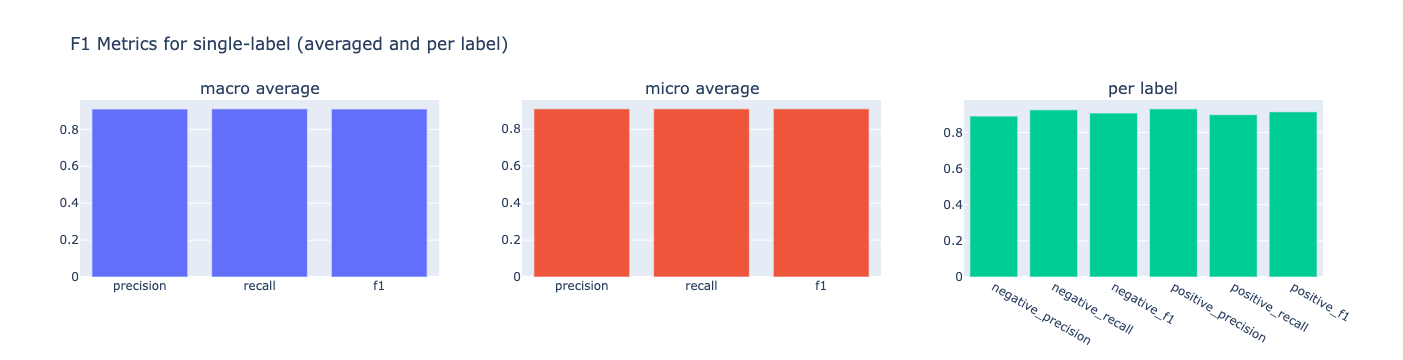

In [13]:
from rubrix.metrics.text_classification import f1

f1(name="sst2").visualize()

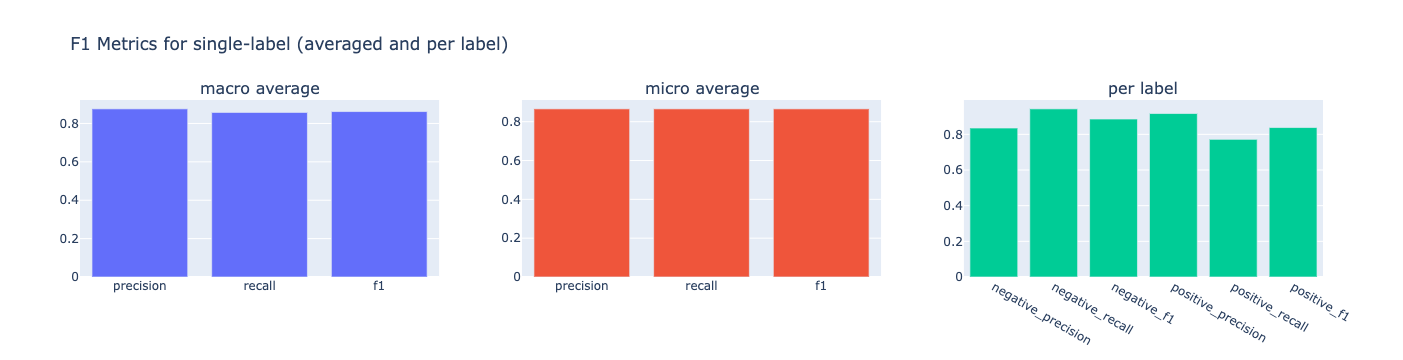

In [20]:
# now compute metrics for negation ( -> negative precision and positive recall go down)
f1(name="sst2", query="n't OR not").visualize()